In [1]:
import pandas as pd
import numpy as np
import torch
pd.set_option('display.max_columns', None) 
from modules.preprocessing import prepare_columns

In [2]:
uber_trips = prepare_columns()

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt



# ============================================================================
# TRAIN/TEST SPLIT (BEFORE PROCESSING)
# ============================================================================
print("="*70)
print("TRAIN/TEST SPLIT (ON RAW DATA)")
print("="*70)

data_raw = uber_trips.copy()

train_data_raw, test_data_raw = train_test_split(
    data_raw, 
    test_size=0.2, 
    random_state=42
)

print(f"Original data size: {len(data_raw)}")
print(f"Training data size (raw): {len(train_data_raw)}")
print(f"Testing data size (raw): {len(test_data_raw)}")
print(f"Train/Test Split: 80/20\n")




TRAIN/TEST SPLIT (ON RAW DATA)
Original data size: 10000
Training data size (raw): 8000
Testing data size (raw): 2000
Train/Test Split: 80/20



In [4]:
train_data_raw

,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,out_of_base_dispatch_flag,final_fare,uber_profit,driver_final_pay,uber_profit_per_mile,uber_profit_per_second,pickup_date,wait,day_of_month,time_of_day,precip,preciptype
9254,61,222,4.16,1156,16.80,0.00,0.50,1.49,0.00,0.0,0.00,18.66,N,N,0,18.79,-1.36,18.16,-0.326923,-0.001176,2021-01-01,181.0,1,night,15.33,rain
1561,129,83,0.68,371,9.38,0.00,0.00,0.00,0.00,0.0,0.00,7.98,N,N,0,9.38,1.40,7.98,2.058824,0.003774,2021-01-01,296.0,1,night,15.33,rain
1670,157,42,7.67,945,19.07,6.12,0.76,2.24,0.00,0.0,0.00,16.99,N,N,0,28.19,8.96,10.11,1.168188,0.009481,2021-01-01,181.0,1,night,15.33,rain
6087,47,235,3.72,936,15.91,0.00,0.48,1.41,0.00,0.0,0.00,13.96,N,N,0,17.80,2.43,13.48,0.653226,0.002596,2021-01-01,162.0,1,night,15.33,rain
6669,75,159,3.33,1017,14.16,0.00,0.42,1.26,0.00,0.0,0.00,13.04,N,N,0,15.84,1.54,12.62,0.462462,0.001514,2021-01-01,157.0,1,night,15.33,rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,248,182,1.24,360,7.91,0.00,0.24,0.70,0.00,0.0,0.00,7.16,N,N,0,8.85,0.99,6.92,0.798387,0.002750,2021-01-01,298.0,1,night,15.33,rain
5191,255,211,3.66,828,14.59,0.00,0.50,1.30,2.75,0.0,0.94,12.00,N,N,0,19.14,5.84,9.69,1.595628,0.007053,2021-01-01,92.0,1,night,15.33,rain
5390,41,42,1.77,546,10.33,0.00,0.31,0.92,0.00,0.0,0.00,8.25,N,N,0,11.56,2.39,7.94,1.350282,0.004377,2021-01-01,220.0,1,night,15.33,rain
860,18,212,3.82,815,13.06,0.00,0.56,1.64,0.00,0.0,0.00,11.96,N,N,0,15.26,1.66,11.40,0.434555,0.002037,2021-01-01,572.0,1,night,15.33,rain


In [5]:
# ============================================================================
# STATIC PRICING WITH PROBABILISTIC ACCEPTANCE
# ============================================================================
static_test_data = test_data_raw.copy()
def calculate_acceptance_rate(predicted_price, actual_fare):
    """
    Calculate acceptance probability based on price difference
    Closer to actual fare = higher acceptance
    """
    if actual_fare <= 0:
        return 0.0
    
    price_diff = abs(predicted_price - actual_fare)
    max_acceptable_diff = actual_fare * 0.5  #deviation threshold
    
    #log 
    acceptance_rate = 1.0 / (1.0 + np.exp((price_diff - max_acceptable_diff) / (max_acceptable_diff * 0.1)))
    return np.clip(acceptance_rate, 0.0, 1.0)  

average_price_per_mile = static_test_data['final_fare'].sum() / static_test_data['trip_miles'].sum()
static_per_mile_pricing = static_test_data.copy()
static_per_mile_pricing['static_price'] = (static_per_mile_pricing['trip_miles'] * average_price_per_mile) + static_per_mile_pricing["tolls"] + static_per_mile_pricing['bcf'] + static_per_mile_pricing['sales_tax'] + static_per_mile_pricing['congestion_surcharge'] + static_per_mile_pricing["airport_fee"]

static_per_mile_pricing['acceptance_rate'] = static_per_mile_pricing.apply(
    lambda row: calculate_acceptance_rate(row['static_price'], row['final_fare']),
    axis=1
)

np.random.seed(42)
static_per_mile_pricing['is_accepted'] = static_per_mile_pricing['acceptance_rate'].apply(
    lambda rate: np.random.rand() < rate
)

static_per_mile_pricing['static_profit'] = static_per_mile_pricing.apply(
    lambda row: row['static_price'] - row['driver_pay'] - row["sales_tax"] if row['is_accepted'] else 0,
    axis=1
)

average_profit_per_ride = static_per_mile_pricing['static_profit'].mean()
average_fare_per_ride = static_per_mile_pricing['static_price'].mean()
static_acceptance_rate = static_per_mile_pricing['is_accepted'].mean()
static_accepted_rides = static_per_mile_pricing['is_accepted'].sum()
static_total_revenue = static_per_mile_pricing[static_per_mile_pricing['is_accepted']]['static_price'].sum()
static_avg_revenue_per_ride = static_total_revenue / len(static_per_mile_pricing)

print("="*70)
print("STATIC PRICING STRATEGY WITH PROBABILISTIC ACCEPTANCE")
print("="*70)
print(f"Average Price Per Mile: ${average_price_per_mile:.2f}")
print(f"Average Profit Per Ride: ${average_profit_per_ride:.2f}")
print(f"Average Fare Per Ride: ${average_fare_per_ride:.2f}")
print(f"Average Revenue Per Ride: ${static_avg_revenue_per_ride:.2f}")
print(f"Acceptance Rate: {static_acceptance_rate:.2%}")
print(f"Accepted Rides: {static_accepted_rides} / {len(static_per_mile_pricing)}")
print(f"Total Revenue: ${static_total_revenue:.2f}")

print("\n" + "="*70)
print("PROFIT STATISTICS")
print("="*70)
print(static_per_mile_pricing['static_profit'].describe())

print("\n" + "="*70)
print("PRICE STATISTICS")
print("="*70)
print(static_per_mile_pricing['static_price'].describe())

print("\n" + "="*70)
print("ACCEPTANCE RATE STATISTICS")
print("="*70)
print(static_per_mile_pricing['acceptance_rate'].describe())

STATIC PRICING STRATEGY WITH PROBABILISTIC ACCEPTANCE
Average Price Per Mile: $4.46
Average Profit Per Ride: $3.82
Average Fare Per Ride: $23.39
Average Revenue Per Ride: $16.23
Acceptance Rate: 81.90%
Accepted Rides: 1638 / 2000
Total Revenue: $32466.10

PROFIT STATISTICS
count    2000.000000
mean        3.817332
std         8.919342
min       -22.250733
25%        -0.235810
50%         0.723838
75%         5.448998
max        94.019676
Name: static_profit, dtype: float64

PRICE STATISTICS
count    2000.000000
mean       23.392635
std        21.630475
min         0.947604
25%         9.127040
50%        16.187274
75%        28.820987
max       156.935431
Name: static_price, dtype: float64

ACCEPTANCE RATE STATISTICS
count    2000.000000
mean        0.821412
std         0.324943
min         0.000000
25%         0.845326
50%         0.996301
75%         0.999733
max         0.999954
Name: acceptance_rate, dtype: float64


FEATURE ENGINEERING CONFIGURATION
Numerical Features (5): ['trip_miles', 'tips', 'wait', 'day_of_month', 'precip']
Categorical Features (6): ['PULocationID', 'DOLocationID', 'preciptype', 'time_of_day', 'shared_request_flag', 'shared_match_flag']
Target Feature: final_fare

FEATURE ENGINEERING (FIT ON TRAINING DATA)
Fitting and scaling numerical features on training data...
Fitting and one-hot encoding categorical features on training data...

Processed Training Data Shape: (8000, 497)
Processed Testing Data Shape: (2000, 497)
State Size: 496
Action Size: 11

Processed columns:
   1. trip_miles
   2. tips
   3. wait
   4. day_of_month
   5. precip
   6. PULocationID_4
   7. PULocationID_5
   8. PULocationID_6
   9. PULocationID_7
  10. PULocationID_9
  11. PULocationID_10
  12. PULocationID_11
  13. PULocationID_13
  14. PULocationID_14
  15. PULocationID_15
  16. PULocationID_16
  17. PULocationID_17
  18. PULocationID_18
  19. PULocationID_19
  20. PULocationID_20
  21. PULocationID_

/Users/diclebulut/Desktop/CODING/GITHUB_PROJECTS/dynamic-pricing-uber-data/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


       trip_miles       tips       wait  day_of_month  precip  PULocationID_4  \
count   8000.0000  8000.0000  8000.0000        8000.0  8000.0       8000.0000   
mean      -0.0000    -0.0000     0.0000           0.0    -0.0          0.0044   
std        1.0001     1.0001     1.0001           0.0     0.0          0.0660   
min       -1.0032    -0.2408    -1.6806           0.0    -0.0          0.0000   
25%       -0.6432    -0.2408    -0.6846           0.0    -0.0          0.0000   
50%       -0.3321    -0.2408    -0.2458           0.0    -0.0          0.0000   
75%        0.2791    -0.2408     0.4715           0.0    -0.0          0.0000   
max       18.2184    18.2930     7.8611           0.0    -0.0          1.0000   

       PULocationID_5  PULocationID_6  PULocationID_7  PULocationID_9  \
count       8000.0000       8000.0000       8000.0000       8000.0000   
mean           0.0001          0.0009          0.0091          0.0002   
std            0.0112          0.0296          0.09

/var/folders/j8/2xxj5v895d3gt_n2nn9rwx7r0000gn/T/ipykernel_5926/3281856607.py:157: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_rate = 1.0 / (1.0 + np.exp((price_diff - max_acceptable_diff) / (max_acceptable_diff * 0.1)))


Episode  30/100 | Avg Reward:  1.1980 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  40/100 | Avg Reward:  1.1972 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  50/100 | Avg Reward:  1.1752 | Acceptance Rate: 99.00% | Epsilon: 0.0100
Episode  60/100 | Avg Reward:  1.1564 | Acceptance Rate: 99.00% | Epsilon: 0.0100
Episode  70/100 | Avg Reward:  1.1912 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  80/100 | Avg Reward:  1.1844 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  90/100 | Avg Reward:  1.1820 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode 100/100 | Avg Reward:  1.1860 | Acceptance Rate: 100.00% | Epsilon: 0.0100

TRAINING COMPLETED


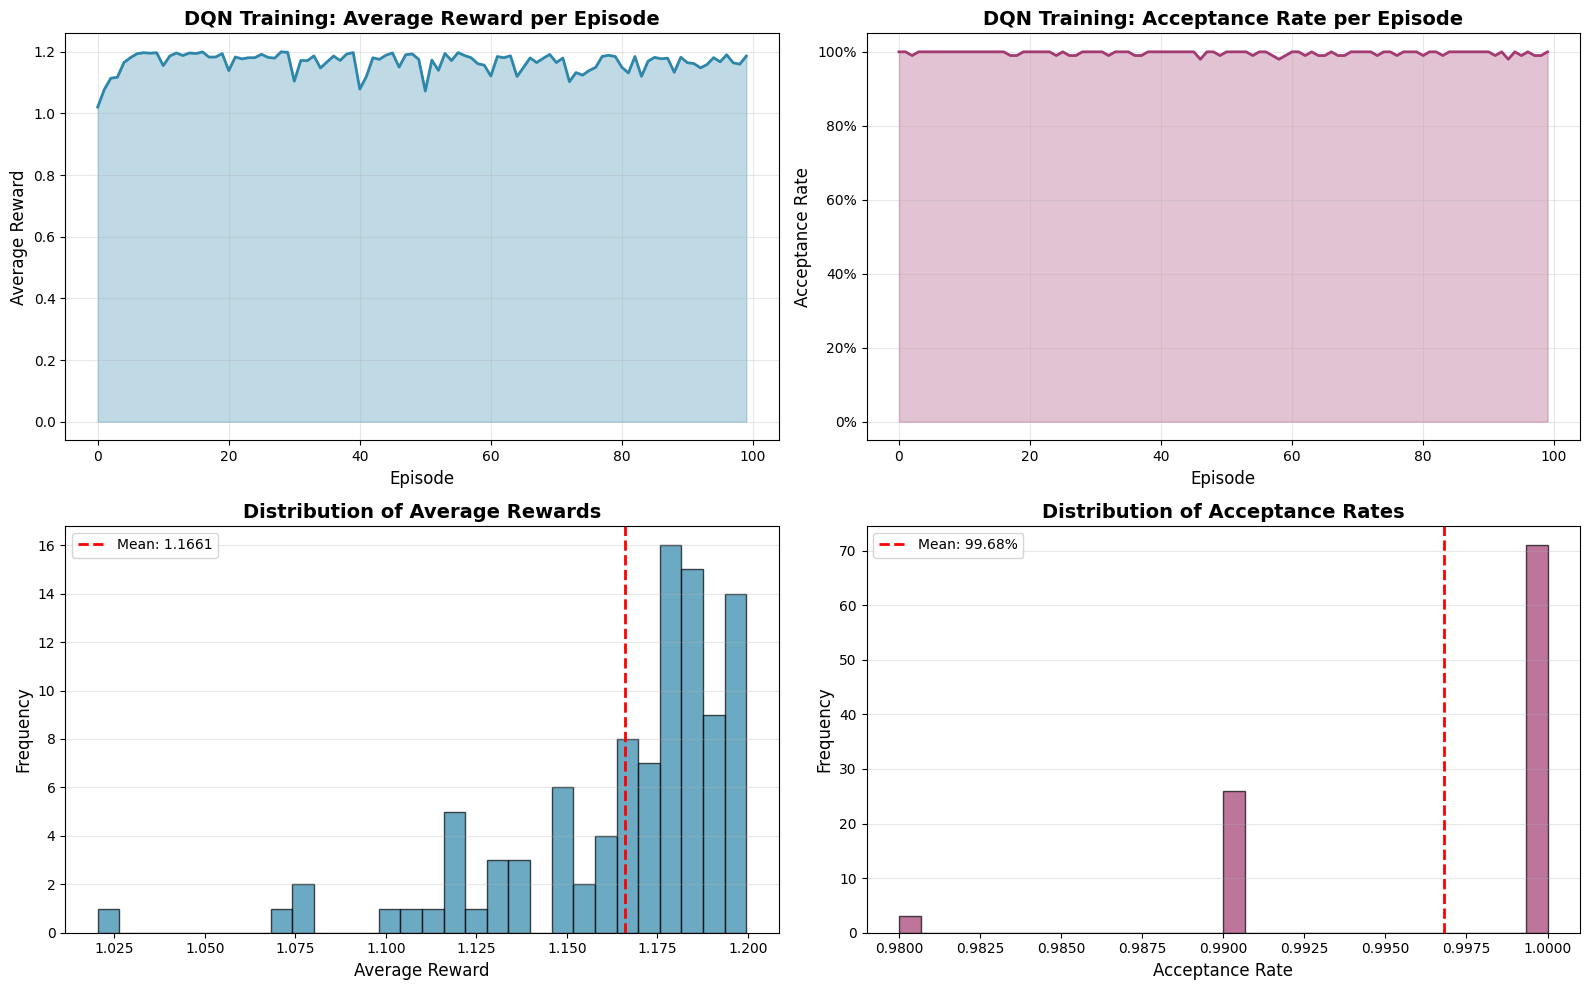


TESTING TRAINED MODEL

Test Results (Average over 20 episodes):
  Average Reward: 1.1894
  Std Dev Reward: 0.0059
  Average Acceptance Rate: 99.70%
  Average Revenue Multiplier: 1.1930x
  Min Multiplier: 1.1600x
  Max Multiplier: 1.2000x

Price Statistics:
  Average Predicted Price: $23.78
  Min Predicted Price: $0.00
  Max Predicted Price: $148.63
  Total Accepted Rides: 1994
  Total Test Predictions: 2000

COMPARISON: DYNAMIC PRICING (DQN) vs STATIC PRICING

STATIC PRICING METRICS:
  Average Fare Per Ride: $23.39
  Total Revenue: $32466.10
  Average Revenue Per Ride: $16.23
  Acceptance Rate: 81.90%
  Accepted Rides: 1638 / 2000

DQN DYNAMIC PRICING METRICS:
  Average Expected Revenue Multiplier: 1.1894x
  Average Acceptance Rate: 99.70%
  Total Revenue from 2000 test rides: $47453.64
  Average Revenue per Ride: $23.73
  Accepted Rides: 1994 (99.70%)

REVENUE COMPARISON:
  Static Total Revenue: $32466.10
  DQN Total Revenue: $47453.64
  Revenue Difference: $14987.53
  Improvement: +

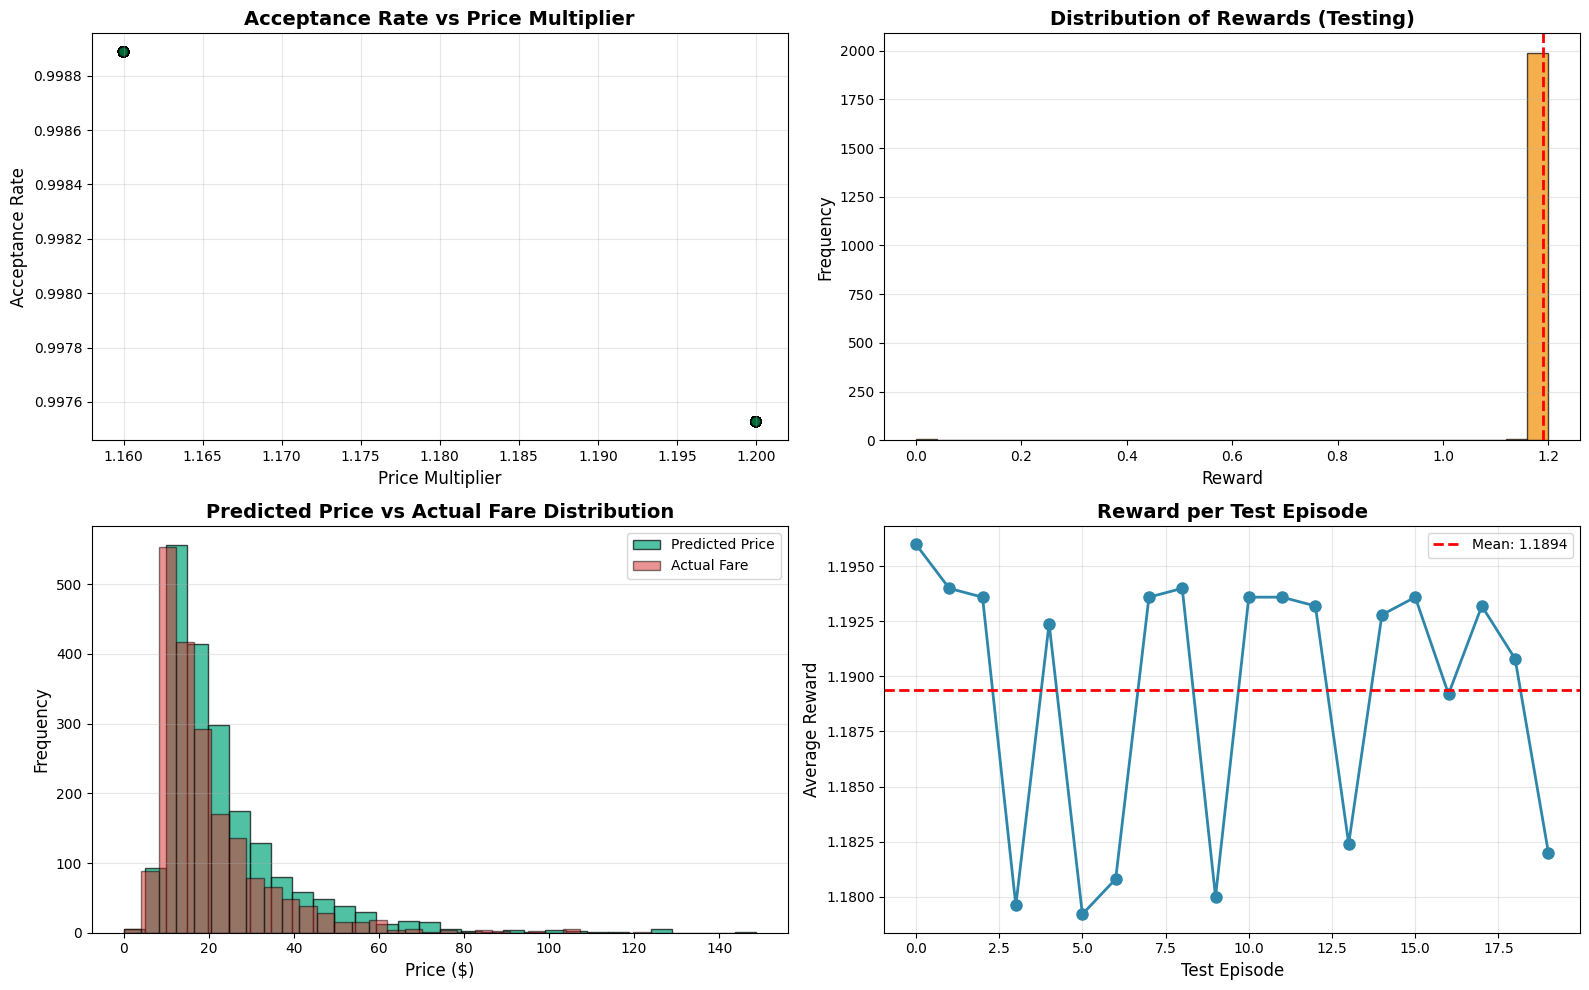


ANALYSIS COMPLETE


In [ ]:
# ============================================================================
# prepare data
# ============================================================================

train_data_raw = train_data_raw[['PULocationID', 'DOLocationID', 'trip_miles',
                              'tips','shared_request_flag', 'shared_match_flag',
                              'final_fare', 'wait', 'day_of_month',
                            'time_of_day', 'precip', 'preciptype']]
test_data_raw = test_data_raw[['PULocationID', 'DOLocationID', 'trip_miles',
                              'tips','shared_request_flag', 'shared_match_flag',
                              'final_fare', 'wait', 'day_of_month',
                            'time_of_day', 'precip', 'preciptype']]

numerical_features = [ 'trip_miles', 'tips', 
                      'wait', 'day_of_month',  'precip']
categorical_features = ['PULocationID', 'DOLocationID','preciptype', 'time_of_day', 'shared_request_flag', 'shared_match_flag']
target_feature = 'final_fare'

print("="*70)
print("FEATURE ENGINEERING CONFIGURATION")
print("="*70)
print(f"Numerical Features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features}")
print(f"Target Feature: {target_feature}\n")

# ============================================================================
# FEATURE ENGINEERING 
# ============================================================================
print("="*70)
print("FEATURE ENGINEERING (FIT ON TRAINING DATA)")
print("="*70)

scaler = StandardScaler()
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

print("Fitting and scaling numerical features on training data...")
scaler.fit(train_data_raw[numerical_features])
train_numerical_data = scaler.transform(train_data_raw[numerical_features])
test_numerical_data = scaler.transform(test_data_raw[numerical_features])

train_numerical_df = pd.DataFrame(
    train_numerical_data, 
    columns=numerical_features, 
    index=train_data_raw.index
)

test_numerical_df = pd.DataFrame(
    test_numerical_data, 
    columns=numerical_features, 
    index=test_data_raw.index
)

print("Fitting and one-hot encoding categorical features on training data...")
one_hot_encoder.fit(train_data_raw[categorical_features])
train_categorical_data = one_hot_encoder.transform(train_data_raw[categorical_features])
test_categorical_data = one_hot_encoder.transform(test_data_raw[categorical_features])

categorical_feature_names = list(one_hot_encoder.get_feature_names_out(categorical_features))

train_categorical_df = pd.DataFrame(
    train_categorical_data, 
    columns=categorical_feature_names, 
    index=train_data_raw.index
)

test_categorical_df = pd.DataFrame(
    test_categorical_data, 
    columns=categorical_feature_names, 
    index=test_data_raw.index
)

train_data = pd.concat([train_numerical_df, train_categorical_df], axis=1)
train_data[target_feature] = train_data_raw[target_feature].values

test_data = pd.concat([test_numerical_df, test_categorical_df], axis=1)
test_data[target_feature] = test_data_raw[target_feature].values

state_size = len(train_data.columns) - 1  
action_size = 11

print(f"\nProcessed Training Data Shape: {train_data.shape}")
print(f"Processed Testing Data Shape: {test_data.shape}")
print(f"State Size: {state_size}")
print(f"Action Size: {action_size}\n")

print("Processed columns:")
for i, col in enumerate(train_data.columns, 1):
    print(f"  {i:2d}. {col}")

print("\n" + "="*70)
print("CATEGORICAL ENCODING DETAILS")
print("="*70)
print(f"One-hot encoded features ({len(categorical_feature_names)}):")
for feat in categorical_feature_names:
    print(f"  - {feat}")

print("\n" + "="*70)
print("TRAINING DATA STATISTICS")
print("="*70)
print(train_data.describe().round(4))

print("\n" + "="*70)
print("TESTING DATA STATISTICS")
print("="*70)
print(test_data.describe().round(4))


class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# ============================================================================
# env
# ============================================================================
class PricingEnvironment:
    """Environment that simulates pricing decisions with acceptance rates"""
    
    def __init__(self, data, num_price_actions=11):
        self.data = data.reset_index(drop=True)
        self.num_price_actions = num_price_actions
        self.current_idx = 0
        self.state_columns = [col for col in data.columns if col != target_feature]
        
        self.price_multipliers = np.linspace(0.8, 1.2, num_price_actions)
        
    def reset(self):
        """Reset environment to random trip"""
        self.current_idx = random.randint(0, len(self.data) - 1)
        return self._get_state()
    
    def _get_state(self):
        """Get current state (trip features)"""
        trip = self.data.iloc[self.current_idx]
        state = np.array([trip[col] for col in self.state_columns], dtype=np.float32)
        return state
    
    def _calculate_acceptance_rate(self, predicted_price, actual_fare):
        """
        Calculate acceptance probability based on price difference
        Closer to actual fare = higher acceptance
        """
        price_diff = abs(predicted_price - actual_fare)
        max_acceptable_diff = actual_fare * 0.5  
        
        acceptance_rate = 1.0 / (1.0 + np.exp((price_diff - max_acceptable_diff) / (max_acceptable_diff * 0.1)))
        return acceptance_rate
    
    def step(self, action):
        """Execute action and return reward"""
        trip = self.data.iloc[self.current_idx]
        actual_fare = trip[target_feature]
        
        multiplier = self.price_multipliers[action]
        predicted_price = actual_fare * multiplier
        
        acceptance_rate = self._calculate_acceptance_rate(predicted_price, actual_fare)
        
        is_accepted = np.random.rand() < acceptance_rate
        
        if is_accepted:
            reward = predicted_price / actual_fare  
        else:
            reward = 0.0
        
        self.current_idx = (self.current_idx + 1) % len(self.data)
        done = False
        
        next_state = self._get_state()
        
        return next_state, reward, done, {
            'predicted_price': predicted_price,
            'actual_fare': actual_fare,
            'acceptance_rate': acceptance_rate,
            'is_accepted': is_accepted,
            'multiplier': multiplier
        }

# ============================================================================
# agent
# ============================================================================
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size

        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.target_model.load_state_dict(self.model.state_dict())
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        self.gamma = 0.95  
        self.epsilon = 1.0  
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.memory = deque(maxlen=2000)
        
    def remember(self, state, action, reward, next_state, done):
        """Store experience in memory"""
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        """Choose action using epsilon-greedy"""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return np.argmax(q_values.cpu().numpy()[0])
    
    def replay(self, batch_size):
        """Train on minibatch from memory"""
        if len(self.memory) < batch_size:
            return
        
        minibatch = random.sample(self.memory, batch_size)
        
        states = torch.FloatTensor(np.array([x[0] for x in minibatch]))
        actions = torch.LongTensor(np.array([x[1] for x in minibatch]))
        rewards = torch.FloatTensor(np.array([x[2] for x in minibatch]))
        next_states = torch.FloatTensor(np.array([x[3] for x in minibatch]))
        dones = torch.FloatTensor(np.array([x[4] for x in minibatch]))
        
        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        with torch.no_grad():
            next_q_values = self.target_model(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        loss = self.criterion(q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def update_target_model(self):
        """Update target network"""
        self.target_model.load_state_dict(self.model.state_dict())

# ============================================================================
# training
# ============================================================================

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
num_episodes = 100
batch_size = 32
update_frequency = 10


env_train = PricingEnvironment(train_data, num_price_actions=action_size)
env_test = PricingEnvironment(test_data, num_price_actions=action_size)

agent = DQNAgent(state_size, action_size, learning_rate=0.001)

episode_rewards = []
episode_acceptances = []
episode_losses = []

print("\n" + "="*70)
print("DQN TRAINING FOR DYNAMIC PRICING")
print("="*70)
print(f"Episodes: {num_episodes}")
print(f"Batch Size: {batch_size}")
print(f"Update Frequency: {update_frequency}")
print(f"Initial Epsilon: {agent.epsilon}")
print(f"Discount Factor (Gamma): {agent.gamma}\n")

for episode in range(num_episodes):
    state = env_train.reset()
    episode_reward = 0
    episode_accepted = 0
    episode_steps = min(len(env_train.data), 100)
    
    for step in range(episode_steps):
        action = agent.act(state)
        next_state, reward, done, info = env_train.step(action)
        
        agent.remember(state, action, reward, next_state, done)
        agent.replay(batch_size)
        
        episode_reward += reward
        episode_accepted += int(info['is_accepted'])
        state = next_state
    
    if (episode + 1) % update_frequency == 0:
        agent.update_target_model()
    
    episode_rewards.append(episode_reward / episode_steps)
    episode_acceptances.append(episode_accepted / episode_steps)
    
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1:3d}/{num_episodes} | "
              f"Avg Reward: {episode_rewards[-1]:7.4f} | "
              f"Acceptance Rate: {episode_acceptances[-1]:6.2%} | "
              f"Epsilon: {agent.epsilon:.4f}")

print("\n" + "="*70)
print("TRAINING COMPLETED")
print("="*70)

# ============================================================================
# VIZ
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))


ax1 = axes[0, 0]
ax1.plot(episode_rewards, linewidth=2, color='#2E86AB')
ax1.fill_between(range(len(episode_rewards)), episode_rewards, alpha=0.3, color='#2E86AB')
ax1.set_xlabel('Episode', fontsize=12)
ax1.set_ylabel('Average Reward', fontsize=12)
ax1.set_title('DQN Training: Average Reward per Episode', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
ax2.plot(episode_acceptances, linewidth=2, color='#A23B72')
ax2.fill_between(range(len(episode_acceptances)), episode_acceptances, alpha=0.3, color='#A23B72')
ax2.set_xlabel('Episode', fontsize=12)
ax2.set_ylabel('Acceptance Rate', fontsize=12)
ax2.set_title('DQN Training: Acceptance Rate per Episode', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

ax3 = axes[1, 0]
ax3.hist(episode_rewards, bins=30, color='#2E86AB', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Average Reward', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of Average Rewards', fontsize=14, fontweight='bold')
ax3.axvline(np.mean(episode_rewards), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(episode_rewards):.4f}')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

ax4 = axes[1, 1]
ax4.hist(episode_acceptances, bins=30, color='#A23B72', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Acceptance Rate', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Distribution of Acceptance Rates', fontsize=14, fontweight='bold')
ax4.axvline(np.mean(episode_acceptances), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(episode_acceptances):.2%}')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================================
# test
# ============================================================================
print("\n" + "="*70)
print("TESTING TRAINED MODEL")
print("="*70)

test_episodes = 20
steps_per_episode = 100
test_rewards = []
test_acceptances = []
test_prices = []
test_multipliers = []
test_details = []

for episode in range(test_episodes):
    state = env_test.reset()
    episode_reward = 0
    episode_accepted = 0
    
    for step in range(steps_per_episode):
        #greedy
        agent.epsilon = 0
        action = agent.act(state)
        next_state, reward, done, info = env_test.step(action)
        
        episode_reward += reward
        episode_accepted += int(info['is_accepted'])
        test_prices.append(info['predicted_price'])
        test_multipliers.append(info['multiplier'])
        
        test_details.append({
            'predicted_price': info['predicted_price'],
            'actual_fare': info['actual_fare'],
            'acceptance_rate': info['acceptance_rate'],
            'is_accepted': info['is_accepted'],
            'multiplier': info['multiplier'],
            'reward': reward
        })
        
        state = next_state
    
    test_rewards.append(episode_reward / steps_per_episode)
    test_acceptances.append(episode_accepted / steps_per_episode)

test_results_df = pd.DataFrame(test_details)

print(f"\nTest Results (Average over {test_episodes} episodes):")
print(f"  Average Reward: {np.mean(test_rewards):.4f}")
print(f"  Std Dev Reward: {np.std(test_rewards):.4f}")
print(f"  Average Acceptance Rate: {np.mean(test_acceptances):.2%}")
print(f"  Average Revenue Multiplier: {np.mean(test_multipliers):.4f}x")
print(f"  Min Multiplier: {np.min(test_multipliers):.4f}x")
print(f"  Max Multiplier: {np.max(test_multipliers):.4f}x")

print("\nPrice Statistics:")
print(f"  Average Predicted Price: ${np.mean(test_prices):.2f}")
print(f"  Min Predicted Price: ${np.min(test_prices):.2f}")
print(f"  Max Predicted Price: ${np.max(test_prices):.2f}")
print(f"  Total Accepted Rides: {test_results_df['is_accepted'].sum()}")
print(f"  Total Test Predictions: {len(test_results_df)}")

# ============================================================================
# COMPARISON
# ============================================================================
print("\n" + "="*70)
print("COMPARISON: DYNAMIC PRICING (DQN) vs STATIC PRICING")
print("="*70)

#dqn rev estimate
dqn_accepted_rides = test_results_df['is_accepted'].sum()
dqn_total_revenue = test_results_df[test_results_df['is_accepted']]['predicted_price'].sum()
dqn_avg_revenue_per_ride = dqn_total_revenue / len(test_results_df)

print("\nSTATIC PRICING METRICS:")
print(f"  Average Fare Per Ride: ${average_fare_per_ride:.2f}")
print(f"  Total Revenue: ${static_total_revenue:.2f}")
print(f"  Average Revenue Per Ride: ${static_avg_revenue_per_ride:.2f}")
print(f"  Acceptance Rate: {static_acceptance_rate:.2%}")
print(f"  Accepted Rides: {static_accepted_rides} / {len(static_per_mile_pricing)}")

print("\nDQN DYNAMIC PRICING METRICS:")
print(f"  Average Expected Revenue Multiplier: {np.mean(test_rewards):.4f}x")
print(f"  Average Acceptance Rate: {np.mean(test_acceptances):.2%}")
print(f"  Total Revenue from {len(test_results_df)} test rides: ${dqn_total_revenue:.2f}")
print(f"  Average Revenue per Ride: ${dqn_avg_revenue_per_ride:.2f}")
print(f"  Accepted Rides: {dqn_accepted_rides} ({dqn_accepted_rides/len(test_results_df):.2%})")

print("\nREVENUE COMPARISON:")
revenue_difference = dqn_total_revenue - static_total_revenue
revenue_improvement_pct = (revenue_difference / static_total_revenue * 100) if static_total_revenue > 0 else 0
print(f"  Static Total Revenue: ${static_total_revenue:.2f}")
print(f"  DQN Total Revenue: ${dqn_total_revenue:.2f}")
print(f"  Revenue Difference: ${revenue_difference:.2f}")
print(f"  Improvement: {revenue_improvement_pct:+.2f}%")

# ============================================================================
# VIZ
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

#acceptence rate by multiplier
ax1 = axes[0, 0]
ax1.scatter(test_results_df['multiplier'], test_results_df['acceptance_rate'], 
            alpha=0.5, s=50, c=test_results_df['is_accepted'], cmap='RdYlGn', edgecolors='black')
ax1.set_xlabel('Price Multiplier', fontsize=12)
ax1.set_ylabel('Acceptance Rate', fontsize=12)
ax1.set_title('Acceptance Rate vs Price Multiplier', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

#reward dist
ax2 = axes[0, 1]
ax2.hist(test_results_df['reward'], bins=30, color='#F18F01', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Reward', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Rewards (Testing)', fontsize=14, fontweight='bold')
ax2.axvline(np.mean(test_results_df['reward']), color='red', linestyle='--', linewidth=2)
ax2.grid(True, alpha=0.3, axis='y')

#comparison
ax3 = axes[1, 0]
ax3.hist(test_results_df['predicted_price'], bins=30, color='#06A77D', alpha=0.7, label='Predicted Price', edgecolor='black')
ax3.hist(test_results_df['actual_fare'], bins=30, color='#D62828', alpha=0.5, label='Actual Fare', edgecolor='black')
ax3.set_xlabel('Price ($)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Predicted Price vs Actual Fare Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

#episode rewards
ax4 = axes[1, 1]
ax4.plot(test_rewards, marker='o', linewidth=2, markersize=8, color='#2E86AB')
ax4.axhline(np.mean(test_rewards), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(test_rewards):.4f}')
ax4.set_xlabel('Test Episode', fontsize=12)
ax4.set_ylabel('Average Reward', fontsize=12)
ax4.set_title('Reward per Test Episode', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)